<a href="https://colab.research.google.com/github/gsfreitas/data_science/blob/main/Spark_Analise_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

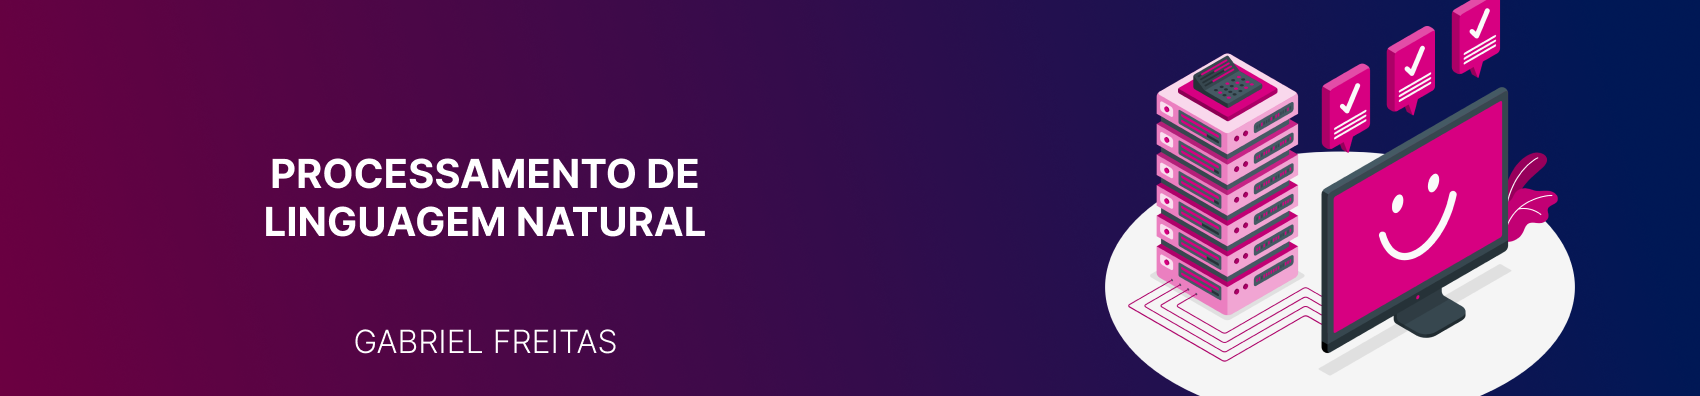

Processamento de Linguagem Natural, mais conhecido como PLN, é uma tecnologia que permite que os coumputadores possam compreender a linguagem humana. Essa área vem sendo cada vez mais sendo desenvolvida e estudada com os avanços tecnológicos.

Esse campo o principal objetivo é ler, decifrar, entender e dar sentido às línguas humanas. É possível também que utilize do Aprendizado de Máquina (Machine Learning) para obter os significados da linguagem humana.

# Introdução

In [1]:
# preparando o ambiente
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importando o pyspark
from pyspark.sql import SparkSession

In [3]:
# iniciando uma sessão spark
spark = SparkSession.builder\
  .master('local[*]')\
  .appName('analise_nlp')\
  .getOrCreate()

In [4]:
# lendo os dados
dados = spark.read.csv('/content/imdb-reviews-pt-br.csv',
                       escape="\"",
                       header=True,
                       inferSchema=True)

**EXPLORANDO OS DADOS**

Chegou a hora de verificar alguns parâmetros antes de aplicar o PNL


* Tamanho dos dados
* Quantidade de colunas
* Conteúdo em cada campo
* Tipo de dados
* Proporção em cada categoria



In [5]:
# tamanho dos dados
print(f'Tamanho dos dados: {dados.count()}')
print(f'Quantidade de colunas: {len(dados.columns)}')

Tamanho dos dados: 49459
Quantidade de colunas: 4


In [6]:
# conteúdo em cada campo e tipo de dados
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [7]:
# conteúdo da base de dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



**FILTRANDO OS COMENTÁRIOS**

Filtragem de alguns comentários negativos e positivos para avaliar se há algum padrão.

In [8]:
print("Comentário Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate=False)

print("Comentário Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate=False)

Comentário Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                      

In [9]:
# contando os tipos de comentários7
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# Limpeza e Processamento

Chegou o momento de realizar a limpeza dos dados. Isso envolve a remoção de alguns dados que não têm muito sentido para nossa análise, como por exmeplo: caracteres especiais e espaços. Também é válido a retirada de algumas tags de html, já que não vão agregar em análises posteriores.

É bastante comum também a remoção das *stop words*, como provérbios e preposições, para trazer uma análise mais acurada e trazer mais valor.

A normalização também é importante nesta etapa, retirando flexões das palavras.

In [10]:
# relembrando os dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



**Word Cloud**

O Word Cloud é um recurso visual muito utilizado para compreender as palavras que mais se repetem e também para entender as possíveis candidatas para a remoção.

In [11]:
# importando as bibliotecas necessárias
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# coletando uma amostra dos depoimentos
amostra = dados.select('text_pt').sample(fraction=0.1,seed=101)

# list comprehention
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [12]:
# criando a wordcloud
wordcloud = WordCloud(background_color="white",
                      width = 1000,
                      height = 600,
                      collocations=False,
                      prefer_horizontal=1).generate(str(tudo))

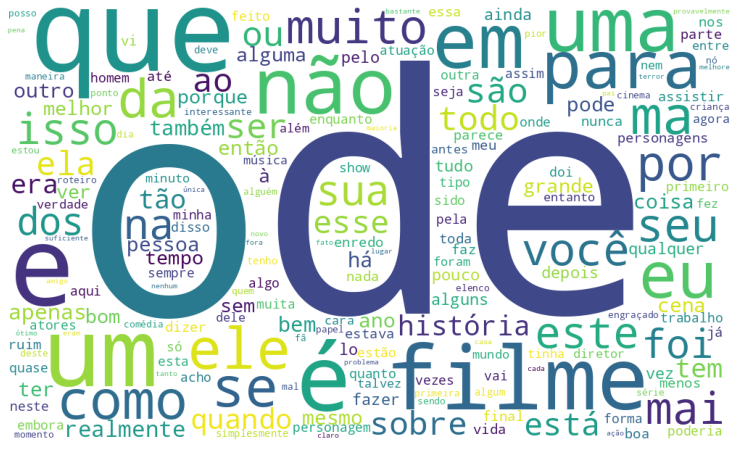

In [13]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [14]:
# removendo os tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
import pyspark.sql.functions as f

In [16]:
# retirando os caracteres especiais dos dados reais
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [17]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
# retirar os espaços no início e fim de cada depoimento
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

In [19]:
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



**Tokenização**

O O objetivo é gerar tokens a partir dos depoimentos, ou seja, repartir a frase em palavras.

In [20]:
from pyspark.ml.feature import Tokenizer

In [21]:
# criando um objeto tokenizer
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [22]:
tokenizado.select('texto_limpo','tokens').limit(10).show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
+--------------------+--------------------+



In [23]:
from pyspark.sql.types import IntegerType

# contando os tokens
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

**StopWords**

Stop Words são palavras que não expressão sentimento algum, ou seja, não dá para saber se ela demonstra um sentimento positivo ou negativo, como por exemplo: de, a, para, por, pelo, etc.

Essas são frequentemente utilizadas, mas que devem ser removidas da nossa análise, justamente por não agregar valor.**negrito**

In [24]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from pyspark.ml.feature import StopWordsRemover

In [26]:
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [27]:
# removendo as stopwords dos depoimentos
remover = StopWordsRemover(inputCol="tokens",outputCol="texto_final")
feature_data = remover.transform(tokenizado)

In [28]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [29]:
# contagem dos tokens antes e depois
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

# Vetorização das Palavras

**Bag of Words**

Processo para contabilizar as palavras com a finalidade de otimizar o processamento. Aqui será representado por uma estrutura específica para a compreensão dos modelos.

In [30]:
from pyspark.ml.feature import CountVectorizer

In [32]:
# instanciando o CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



A saída do CountVectorizer é uma lista com três argumentos.


1. Tamanho do vocabulário
2. Index de cada palavra de acordo com o model.vocabulary
3. Frequência com que a respectiva palavra aparece



**Hashing TF**

É uma alternativa ao CountVectorizer como forma de otimizar o processamento. É uma boa alternativa quando estamos lidando com Big Data, uma vez que é possível limitar a quantidade de palavras!

In [34]:
from pyspark.ml.feature import HashingTF

In [35]:
# instanciando o Hashing TF
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [ ]:
HTFfeaturizedData.select('texto_final','hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



**TF-IDF**

Essa técnica iremos além de contabilizar, ponderar as palavras com conceitos significativos através da fórmula:

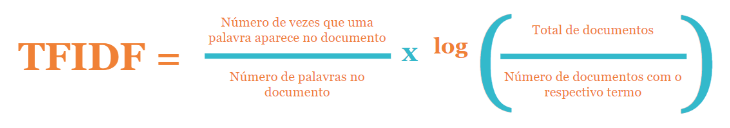

In [36]:
# importando o IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [37]:
TFIDFfeaturizedData.select('texto_final','features').limit(5).show()

+--------------------+--------------------+
|         texto_final|            features|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



In [38]:
# agrupando pela quantidade de tipo de sentimento
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [39]:
from pyspark.ml.feature import StringIndexer

In [40]:
# transformando pos e neg em 0 e 1
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

In [41]:
# conferindo os labels
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [42]:
# Unindo nossas transformações.
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [43]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [44]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# Treinando o Modelo

Após todas as transformações, precisamos escolher o modelo que melhor se aplica para o nosso problema. Sabemos que ele se adequa a um problema de classificação. Podemos citar alguns modelos que melhor se enqaudram para solucionar, como a **Regressão Logística, Árvore de Decisão ou o XGBoost** - que cria um gradiente para categorizar os dados - no nosso caso, os depoimentos

In [45]:
# entendendo os dados
featureDF = dados_transformados.select(['features', 'label'])
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [47]:
#Pipeline de transformação e ajuste
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

In [48]:
# separando nossos dados
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [49]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

In [50]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [51]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [366.0,1112.0]|[0.24763193504736...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

# Teste e Métricas

In [52]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [68]:
evaluator = MulticlassClassificationEvaluator()

In [69]:
# contagem de verdadeiros e negativos
tp = predictions.select('label','prediction').where((f.col('label')==1) & (f.col('prediction')==1)).count()
tn = predictions.select('label','prediction').where((f.col('label')==0) & (f.col('prediction')==0)).count()
fp = predictions.select('label','prediction').where((f.col('label')==0) & (f.col('prediction')==1)).count()
fn = predictions.select('label','prediction').where((f.col('label')==1) & (f.col('prediction')==0)).count()

In [70]:
print(tp,tn,fp,fn)

5208 4722 2791 2099


In [71]:
# mostrando as métricas do modelo
print("Acurácia: %f" % evaluator.evaluate(predictions,{evaluator.metricName: 'accuracy'}))
print("Precisão: %f" % evaluator.evaluate(predictions,{evaluator.metricName: 'precisionByLabel'}))
print("Recall: %f" % evaluator.evaluate(predictions,{evaluator.metricName: 'recallByLabel'}))
print("F1-Score: %f" % evaluator.evaluate(predictions,{evaluator.metricName: 'fMeasureByLabel'}))

Acurácia: 0.670040
Precisão: 0.692274
Recall: 0.628511
F1-Score: 0.658853


In [75]:
# testando com nova frase
nova_base = spark.createDataFrame([
    (1,"This is the worst movie I've ever watched! I hated everything!"),
    (0,"It's the best movie I watch! I loved the actors!")
],["id","texto_limpo"])

In [76]:
nova_class = dt_model.transform(nova_base)

In [77]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features| rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|  1|This is the worst...|[this, is, the, w...|[worst, movie, ev...|(1000,[188,269,33...|(1000,[188,269,33...|  [648.0,88.0]|[0.88043478260869...|       0.0|
|  0|It's the best mov...|[it's, the, best,...|[best, movie, wat...|(1000,[162,439,61...|(1000,[162,439,61...|[366.0,1112.0]|[0.24763193504736...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+

